In [0]:
############### Pytorch CIFAR configuration file ###############
import math
import functions.BinaryConnect as BC
import functions.DataAugmentation as DA
from functions.AutoAugment import AutoAugment, Cutout
from models.WideResnet_HRank import Wide_ResNet_HRank, wide_basic
from torch.nn import init
start_epoch = 1
num_epochs = 140
batch_size = 128
optim_type = 'SGD'

mean = {
    'cifar10': (0.4914, 0.4822, 0.4465),
    'cifar100': (0.5071, 0.4867, 0.4408),
}

std = {
    'cifar10': (0.2023, 0.1994, 0.2010),
    'cifar100': (0.2675, 0.2565, 0.2761),
}

# Only for cifar-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 120):
        optim_factor = 3
    elif(epoch > 80):
        optim_factor = 2
    elif(epoch > 40):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

In [0]:
##### TRAINING CELL #####
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable


import torchvision
import torchvision.transforms as transforms
import numpy as np

import os
import sys
import time
import datetime


#Parameters settings
depth = 40 ##can be 10, 16, 22, 28(default), 34, 40
net_type = 'wide-resnet'
lr = 0.1
widen_factor = 2 #any numer, 10(default)
dropout = 0.3
dataset = 'cifar10'
testOnly = False
resume = False
bc = False
da = True
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
best_acc = 0

# Data Uplaod
print('\n[Phase 1] : Data Preparation')
if da:
    #print("*Using Data Augmentation")
    to_da = DA.DataAugmentation(dataset,aa=True, cut=True)
    if (dataset == 'cifar10'):
        num_classes = 10
    elif (dataset == 'cifar100'):
        num_classes = 100
    trainset_lenght,trainloader, testloader = to_da.load_data()
else:
    #print(\"| Using no Data Augmentation")
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean[dataset], std[dataset]),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean[dataset], std[dataset]),
    ])
    if(dataset == 'cifar10'):
        print("| Preparing CIFAR-10 dataset...")
        sys.stdout.write("| ")
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform = transform_test)
        trainset_length = len(trainset)
        num_classes = 10
    elif(dataset == 'cifar100'):
        print("| Preparing CIFAR-100 dataset...")
        sys.stdout.write("| ")
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform = transform_train)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform = transform_test)
        trainset_length = len(trainset)
        num_classes = 100
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



[Phase 1] : Data Preparation
| Preparing CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified


In [0]:

# Define net
net = Wide_ResNet_HRank(depth, widen_factor, dropout, num_classes)
file_name = 'wide-resnet-hrank'+str(depth)+'x'+str(widen_factor)+str(dataset)


for m in net.modules():
    if isinstance(m,wide_basic):
        m.pruning = False        

if bc:
    to_bc = BC(net)
    net = to_bc.model
    
# Test only option
if (testOnly):
    print('\n[Test Phase] : Model setup')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+dataset+os.sep+file_name+'.t7')
    net = checkpoint['net']

    if use_cuda:
        net.cuda()
        net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True

    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        acc = 100.*correct/total
        print("| Test Result\tAcc@1: %.2f%%" %(acc))

    sys.exit(0)

# Model
print('\n[Phase 2] : Model setup')
if(resume):
    # Load checkpoint
    print('| Resuming from checkpoint...')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+dataset+os.sep+file_name+'.t7')
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
else:
    print('| Building net type [' + net_type + ']...')
    net.apply(conv_init)

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    print('| Going fast AF with C U D A *o* !')

criterion = nn.CrossEntropyLoss()

# Training
def train(epoch):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=learning_rate(lr, epoch), momentum=0.9, weight_decay=5e-4)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        if bc:
            bc.binarization()
            outputs = net(inputs)       # Forward Propagation\n",
            loss = criterion(outputs,targets)
            bc.restore()
            loss.backward()
            bc.clip()
            optimizer.step()
        else:
            outputs = net(inputs)
            loss = criterion(outputs,targets)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (trainset_lenght//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()

def test(epoch):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

        if acc > best_acc:
            print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                    'net':net.module if use_cuda else net,
                    'acc':acc,
                    'epoch':epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            save_point = './checkpoint/'+dataset+os.sep
            if not os.path.isdir(save_point):
                os.mkdir(save_point)
            torch.save(state, save_point+file_name+'.t7')
            best_acc = acc

print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + str(optim_type))

elapsed_time = 0
for epoch in range(start_epoch, start_epoch+num_epochs):
    start_time = time.time()

    train(epoch)
    test(epoch)

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))
torch.save(net,"wide_resnet.pth")
print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))

In [0]:
#Install the module torch_pruning
!pip3 install torch_pruning

In [0]:
def number_of_trainable_params(model):
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        return sum([np.prod(p.size()) for p in model_parameters])

In [0]:
#Fine Tuning
def learning_rate_ft(init, epoch):
    optim_factor = 0
    if(epoch > 3):
        optim_factor = 3
    elif(epoch > 2):
        optim_factor = 2
    elif(epoch > 1):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)
    
def fine_tuning_train(epoch,net,bc = False, num_epochs = 3, lr = 0.001):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=learning_rate_ft(lr, epoch), momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    print('\n => Fine Tuning Epoch #%d, LR=%.4f' %(epoch, learning_rate_ft(lr, epoch)))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        if bc:
            bc.binarization()
            outputs = net(inputs)       # Forward Propagation\n",
            loss = criterion(outputs,targets)
            bc.restore()
            loss.backward()
            bc.clip()
            optimizer.step()
        else:
            outputs = net(inputs)
            loss = criterion(outputs,targets)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (trainset_lenght//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()

def fine_tuning_test(epoch,net):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        if epoch != 0:
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

        if acc > best_acc:
            print('| New Best Accuracy...\t\t\tTop1 = %.2f%%' %(acc))
            print('| Saving Pruned Model...')
            torch.save(net,"wide_resnet.pth")
            best_acc = acc

In [0]:
def saveList(myList,filename):
    # the filename should mention the extension 'npy'
    np.save(filename,myList)
    print("Saved successfully!")

def loadList(filename):
    # the filename should mention the extension 'npy'
    tempNumpyArray=np.load(filename)
    return tempNumpyArray.tolist()

In [0]:
#Hard Pruning
from functions.HardPruning import HardPrunning
from functions.HRankPruning import HRank
from models.Wide_ResNet import Wide_ResNet
import torch_pruning as pruning
import torch
import os
import numpy as np

import matplotlib.pyplot as plt

import time

#Params
depth = 40
net_type = 'wide-resnet'
widen_factor = 2 
dropout = 0.3
dataset = 'cifar10'
num_classes = 10

file_name = 'wide-resnet-'+str(depth)+'x'+str(widen_factor)


#WideResnet 40x2 has 3 layers
net = Wide_ResNet(depth, widen_factor, dropout, num_classes)

#Pruning ratios for each layer
pruning_ratios_layer1 = [[x,0.0,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer2 = [[0.0,x,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer3 = [[0.0,0.0,x] for x in np.linspace(0,0.9,10)]
pruning_ratios = [x for x in np.linspace(0,0.9,10)]

#Pruning based on the score of the filters
fscore_accuracy_layer1 = []
fscore_accuracy_layer2 = []
fscore_accuracy_layer3 = []
fscore_net_weights_layer1 = []
fscore_net_weights_layer2 = []
fscore_net_weights_layer3 = []

initial_weights = number_of_trainable_params(net)

print('[ Weights : {}]'.format(initial_weights))

for r in pruning_ratios_layer3:
    # Load checkpoint
    

    print('| Resuming from checkpoint...')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+dataset+os.sep+file_name+'.t7')
    net = checkpoint['net']
    best_acc = -1000
    print('\n[1] PRUNING-----------------------------------------------------------')
    print('\n=> Pruning Layer 2... | Ratio : {}%'.format(r[2]))
    fscore = HardPrunning(net,r)
    fscore.HardPruning()
    removed_weights = number_of_trainable_params(fscore.model)
    weights_diff = initial_weights - removed_weights

    print('| Weights removed : {} | {}%'.format(weights_diff,int(100 - 100*removed_weights/initial_weights)))
    fscore_net_weights_layer3.append(removed_weights)

    print('\n[2] FINE TUNING-------------------------------------------------------')
    elapsed_time = 0
    for epoch in range(1, 4):
        start_time = time.time()

        fine_tuning_train(epoch,fscore.model)
        fine_tuning_test(epoch, fscore.model)

        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))

    print('\n[3] TESTING -----------------------------------------------------------')
    print('Testing model..')
    print('* Test results : Acc@1 = %.2f%%' %(best_acc))
    print('\n ----------------------------------------------------------------------')
    fscore_accuracy_layer3.append(best_acc.item())
    best_acc = -1000

saveList(fscore_accuracy_layer3,"fscore_accuracy_layer3")
saveList(fscore_net_weights_layer3,"score_net_weights_layer3")



plt.plot(loadList("score_net_weights_layer3.npy"),loadList("fscore_accuracy_layer3.npy"),)
plt.show()




| Wide-Resnet 40x2
Files already downloaded and verified
[ Weights : 2246474]
| Resuming from checkpoint...

[1] PRUNING-----------------------------------------------------------

=> Pruning Net... | Layer1 : 0.0% Layer2 : 0.0% Layer3 : 0.0%
Sending data through the net...
Weak filters have been identified ! 
The net has been pruned ! 
| Weights removed : 0 | 0%

[2] FINE TUNING-------------------------------------------------------

 => Fine Tuning Epoch #1, LR=0.0010
| Epoch [  1/  3] Iter[391/391]		Loss: 0.3279 Acc@1: 93.054%
| Validation Epoch #1			Loss: 0.0045 Acc@1: 94.05%
| New Best Accuracy...			Top1 = 94.05%
| Saving Pruned Model...
| Elapsed time : 0:01:01

 => Fine Tuning Epoch #2, LR=0.0002
| Epoch [  2/  3] Iter[391/391]		Loss: 0.1601 Acc@1: 93.226%
| Validation Epoch #2			Loss: 0.1727 Acc@1: 94.36%
| New Best Accuracy...			Top1 = 94.36%
| Saving Pruned Model...
| Elapsed time : 0:02:02

 => Fine Tuning Epoch #3, LR=0.0000
| Epoch [  3/  3] Iter[391/391]		Loss: 0.1390 Acc

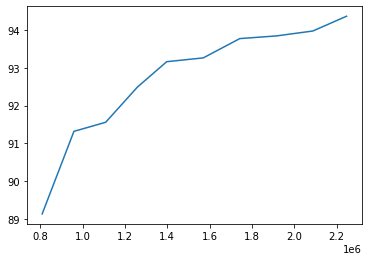

In [0]:
#Hard Rank Pruning
from functions.HRankPruning import HRank
from models.WideResnet_HRank import Wide_ResNet_HRank
import torch_pruning as pruning
import torch
import os
import numpy as np

from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import time

#Params
depth = 40
net_type = 'wide-resnet'
widen_factor = 2 
dropout = 0.3
dataset = 'cifar10'
num_classes = 10

file_name = 'wide-resnet-'+str(depth)+'x'+str(widen_factor)


#WideResnet 40x2 has 3 layers
net = Wide_ResNet_HRank(depth, widen_factor, dropout, num_classes)
net.cuda()
    
#Data for net analysis
def generate_subset(dataset,n_classes,reducefactor,n_ex_class_init):
    nb_examples_per_class = int(np.floor(n_ex_class_init / reducefactor))
    # Generate the indices. They are the same for each class, could easily be modified to have different ones. But be careful to keep the random seed! 
    indices_split = np.random.RandomState(seed=42).choice(n_ex_class_init,nb_examples_per_class,replace=False)
    all_indices = []
    for curclas in range(n_classes):
        curtargets = np.where(np.array(dataset.targets) == curclas)
        indices_curclas = curtargets[0]
        indices_subset = indices_curclas[indices_split]
        #print(len(indices_subset))
        all_indices.append(indices_subset)
    all_indices = np.hstack(all_indices)
    return Subset(dataset,indices=all_indices)

rootdir = './data/'
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)
subset = generate_subset(dataset=c10test,n_classes=10,reducefactor=20,n_ex_class_init=1000)
loader = DataLoader(subset,batch_size=50, num_workers=2)

#Pruning ratios for each layer
pruning_ratios_layer1 = [[x,0.0,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer2 = [[0.0,x,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer3 = [[0.0,0.0,x] for x in np.linspace(0,0.9,10)]
pruning_ratios = [x for x in np.linspace(0,0.9,10)]

#Pruning based on the score of the filters
hscore_accuracy_layer1 = []
hscore_accuracy_layer2 = []
hscore_accuracy_layer3 = []
hscore_net_weights_layer1 = []
hscore_net_weights_layer2 = []
hscore_net_weights_layer3 = []

initial_weights = number_of_trainable_params(net)

print('[ Weights : {}]'.format(initial_weights))

for r in pruning_ratios_layer3:
    # Load checkpoint
    print('| Resuming from checkpoint...')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+dataset+os.sep+file_name+'.t7')
    net = checkpoint['net']
    best_acc = -1000

    print('\n[1] PRUNING-----------------------------------------------------------')
    print('\n=> Pruning Net... | Layer1 : {}% Layer2 : {}% Layer3 : {}%'.format(r[0]*100,r[1]*100,r[2]*100))
    for m in net.modules():
        if isinstance(m,wide_basic):
            m.pruning = True  
    hscore = HRank(net,loader,r)
    hscore.HRank()
    removed_weights = number_of_trainable_params(hscore.model)
    weights_diff = initial_weights - removed_weights
    print('| Weights removed : {} | {}%'.format(weights_diff,int(100 - 100*removed_weights/initial_weights)))
    hscore_net_weights_layer3.append(removed_weights)

    print('\n[2] FINE TUNING-------------------------------------------------------')
    elapsed_time = 0
    for m in net.modules():
        if isinstance(m,wide_basic):
            m.pruning = False  
    for epoch in range(1, 4):
        start_time = time.time()

        fine_tuning_train(epoch,hscore.model)
        fine_tuning_test(epoch,hscore.model)

        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))

    print('\n[3] TESTING -----------------------------------------------------------')
    print('Testing model..')
    print('* Test results : Acc@1 = %.2f%%' %(best_acc))
    print('\n ----------------------------------------------------------------------')
    hscore_accuracy_layer3.append(best_acc.item())
    best_acc = -1000

saveList(hscore_accuracy_layer3,"hscore_accuracy_layer3")
saveList(hscore_net_weights_layer3,"hscore_net_weights_layer3")



plt.plot(loadList("hscore_net_weights_layer3.npy"),loadList("hscore_accuracy_layer3.npy"),)
plt.show()



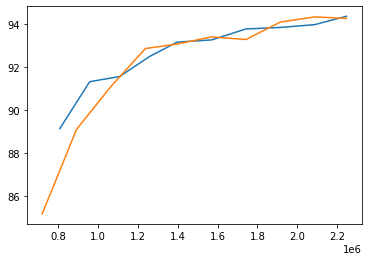

[2246474, 2087282, 1914824, 1742366, 1569908, 1397450, 1259030, 1109075, 959120, 809165]
[2246474, 2087282, 1914824, 1742366, 1569908, 1397450, 1238258, 1065800, 893342, 720884]


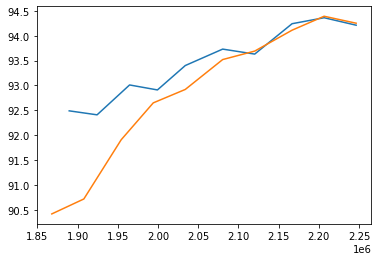

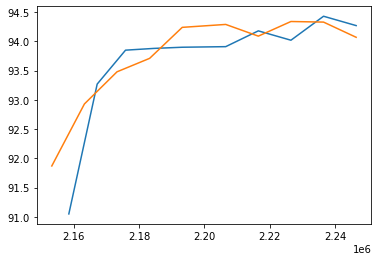

In [0]:
import matplotlib.pyplot as plt

plt.plot(loadList("hscore_net_weights_layer3.npy"),loadList("hscore_accuracy_layer3.npy"))
plt.plot(loadList("score_net_weights_layer3.npy"),loadList("fscore_accuracy_layer3.npy"))
plt.show()

print(loadList("hscore_net_weights_layer3.npy"))
print(loadList("score_net_weights_layer3.npy"))

plt.plot(loadList("hscore_net_weights_layer2.npy"),loadList("hscore_accuracy_layer2.npy"))
plt.plot(loadList("score_net_weights_layer2.npy"),loadList("fscore_accuracy_layer2.npy"))
plt.show()


plt.plot(loadList("hscore_net_weights_layer1.npy"),loadList("hscore_accuracy_layer1.npy"))
plt.plot(loadList("score_net_weights_layer1.npy"),loadList("fscore_accuracy_layer1.npy"))
plt.show()




In [0]:
#Iterative pruning
#Method : Hard Pruning based on the score of the filters
from functions.HardPruningIter import HardPrunningIter
from models.Wide_ResNet import Wide_ResNet
import torch_pruning as pruning
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import time


#Params
depth = 40
net_type = 'wide-resnet'
widen_factor = 2 
dropout = 0.3
dataset = 'cifar10'
num_classes = 10
file_name = 'wide-resnet-'+str(depth)+'x'+str(widen_factor)

#WideResnet 40x2 has 3 layers
net = Wide_ResNet(depth, widen_factor, dropout, num_classes)

#Pruning ratios for each layer
pruning_ratios_layer1 = [[x,0.0,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer2 = [[0.0,x,0.0] for x in np.linspace(0,0.9,10)]
pruning_ratios_layer3 = [[0.0,0.0,x] for x in np.linspace(0,0.9,10)]
pruning_ratios = [x for x in np.linspace(0,0.9,10)]

#Store the results
fscore_iter_accuracy_layer1 = []
fscore_iter_accuracy_layer2 = []
fscore_iter_accuracy_layer3 = []
score_iter_net_weights_layer1 = []
score_iter_net_weights_layer2 = []
score_iter_net_weights_layer3 = []
initial_weights = number_of_trainable_params(net)
test = [[0.0,0.0,0.05],[0,0,0.10]]
print('[ Weights : {}]'.format(initial_weights))

for r in pruning_ratios_layer3:
    print('| Resuming from checkpoint...')
    assert os.path.isdir('checkpoint'), 'Error: No checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+dataset+os.sep+file_name+'.t7')
    net = checkpoint['net']

    fscore_iter = HardPrunningIter(net,r)
    fscore_iter.pruning_and_training(testloader,trainloader,epoch=3)

    fscore_iter_accuracy_layer3.append(fscore_iter.best_acc[-1])
    score_iter_net_weights_layer3.append(fscore_iter.net_weights[-1])


saveList(fscore_iter_accuracy_layer3[:1],"fscore_iter_accuracy_layer3")
saveList(score_iter_net_weights_layer3[:1],"score_iter_net_weights_layer3")


[2213264, 2180054, 2146844, 2080424, 2047214, 2014004, 1980794, 1914374, 1881164] [95.36000061035156, 95.3499984741211, 95.33999633789062, 95.04000091552734, 94.98999786376953, 95.04000091552734, 94.83999633789062, 94.58000183105469, 94.02999877929688]


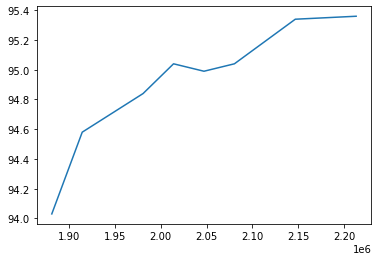

In [0]:

print(loadList("score_iter_net_weights_layer2.npy"),loadList("fscore_iter_accuracy_layer2.npy"))
plt.plot(loadList("score_iter_net_weights_layer2.npy"),loadList("fscore_iter_accuracy_layer2.npy"))
plt.show()

[94.05999755859375]
[2113814]


In [0]:
#Save the weights of the pruned net
model = 'wide_resnet_40x2_pruned_cifar10.pth'
torch.save(net,model)

In [0]:
#Functions for advanced fine tuning
def ft_lr(init, epoch):
    optim_factor = 0
    if(epoch > 9):
        optim_factor = 3
    elif(epoch > 6):
        optim_factor = 2
    elif(epoch > 3):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)
    
def ft_train(epoch,net,bc = False, num_epochs = 140, lr = 0.1):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0
    optimizer = optim.SGD(net.parameters(), lr=ft_lr(lr, epoch), momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    print('\n => Fine Tuning Epoch #%d/%d, LR=%.4f' %(epoch,num_epochs, ft_lr(lr, epoch)))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        if bc:
            bc.binarization()
            outputs = net(inputs)       # Forward Propagation\n",
            loss = criterion(outputs,targets)
            bc.restore()
            loss.backward()
            bc.clip()
            optimizer.step()
        else:
            outputs = net(inputs)
            loss = criterion(outputs,targets)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (trainset_lenght//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()

def ft_test(epoch,net):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100.*correct/total
        if epoch != 0:
          print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

        if acc > best_acc:
            print('| New Best Accuracy...\t\t\tTop1 = %.2f%%' %(acc))
            print('| Saving Model...')
            torch.save(net,"wide_resnet_40x2_pruned_trained_cifar10.pth")
            best_acc = acc

In [0]:
#Fine Tuning with 50 epochs with the pruned model
#The goal is to reach a better accuracy after the pruning

#Params
num_epochs = 10
lr = 0.0002
start_epoch = 1
best_acc = 0
        
print('\n ADVANCED FINE TUNING-------------------------------------------------------')
print('| Fine Tuning Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(lr))
print('| Optimizer = ' + 'SGD')

#Load the pruned model
model = 'wide_resnet_40x2_pruned_cifar10.pth'
brain = torch.load(model)
brain.cuda()

#Advanced fine tuning
elapsed_time = 0
for epoch in range(start_epoch, start_epoch+num_epochs):
    start_time = time.time()

    ft_train(epoch,brain,num_epochs = num_epochs,lr = lr)
    ft_test(epoch,brain)

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))



 ADVANCED FINE TUNING-------------------------------------------------------
| Fine Tuning Epochs = 10
| Initial Learning Rate = 0.0002
| Optimizer = SGD

 => Fine Tuning Epoch #1/10, LR=0.0002
| Epoch [  1/ 10] Iter[261/391]		Loss: 0.3077 Acc@1: 86.434%

KeyboardInterrupt: ignored